<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/regime_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import duckdb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def calculate_percentage_above_moving_average(periods):
    # Connect to DuckDB
    conn = duckdb.connect("candle_data.duckdb")

    # Query only data from '2018-05-01' onwards
    query = """
        SELECT *
        FROM candle_table
        WHERE date >= '2024-01-01'
        ORDER BY date
    """
    # Read data into a Pandas DataFrame
    data = conn.execute(query).df()

    # Close connection
    conn.close()
    data=data.drop_duplicates(subset=['date'], keep='first')
    # Set index to 'date' and convert to DateTime
    data["date"] = pd.to_datetime(data["date"])
    data.set_index("date", inplace=True)

    # Calculate Exponential Moving Average (EMA)
    ma = data.ewm(span=periods, min_periods=periods).mean()

    # Compute percentage of stocks above moving average
    above_ma = data > ma
    percentage = (above_ma.sum(axis=1) / len(above_ma.columns)) * 100


    return percentage



# Calculate the percentage of stocks above their 200 DMA for each day
percentage_above_dma = calculate_percentage_above_moving_average(50)
percentage_50_dma=calculate_percentage_above_moving_average(10)

In [92]:
conn = duckdb.connect("nifty50_data.duckdb")

# Query only data from '2018-05-01' onwards
query = """
    SELECT *
    FROM nifty50_table
    WHERE date >= '2024-01-01'
    ORDER BY date
"""
# Read data into a Pandas DataFrame
nifty = conn.execute(query).df()

# Close connection
conn.close()
nifty=nifty.drop_duplicates(subset=['date'], keep='first')
nifty.dropna(inplace=True)
# Set index to 'date' and convert to DateTime
nifty["date"] = pd.to_datetime(nifty["date"])
nifty.set_index("date", inplace=True)


# Reindex Bank Nifty index data to match percentage_above_dma
aligned_nifty_close = nifty['close']

aligned_nifty_close.head()
pct_20dma=percentage_50_dma.rolling(window=2).mean()
pct_50dma=percentage_above_dma.rolling(window=5).mean()

In [93]:
nifty.tail(5)

,open,high,low,close,volume
date,,,,,
2025-03-21,23168.250000,23402.699219,23132.800781,23350.400391,0
2025-03-24,23515.400391,23708.750000,23433.500000,23658.349609,0
2025-03-25,23751.500000,23869.599609,23601.400391,23668.650391,0
2025-03-26,23700.949219,23736.500000,23451.699219,23486.849609,0
2025-03-27,23433.949219,23646.449219,23412.199219,23591.949219,0


In [94]:
df=pd.DataFrame()
df['Nifty_Close']=aligned_nifty_close
df['Pct_Above_20DMA']=pct_20dma
df['Pct_Above_50DMA']=pct_50dma

In [95]:
df.tail(5)

,Nifty_Close,Pct_Above_20DMA,Pct_Above_50DMA
date,,,
2025-03-21,23350.400391,88.0,50.4
2025-03-24,23658.349609,90.0,56.8
2025-03-25,23668.650391,93.0,62.0
2025-03-26,23486.849609,86.0,65.2
2025-03-27,23591.949219,80.0,66.0


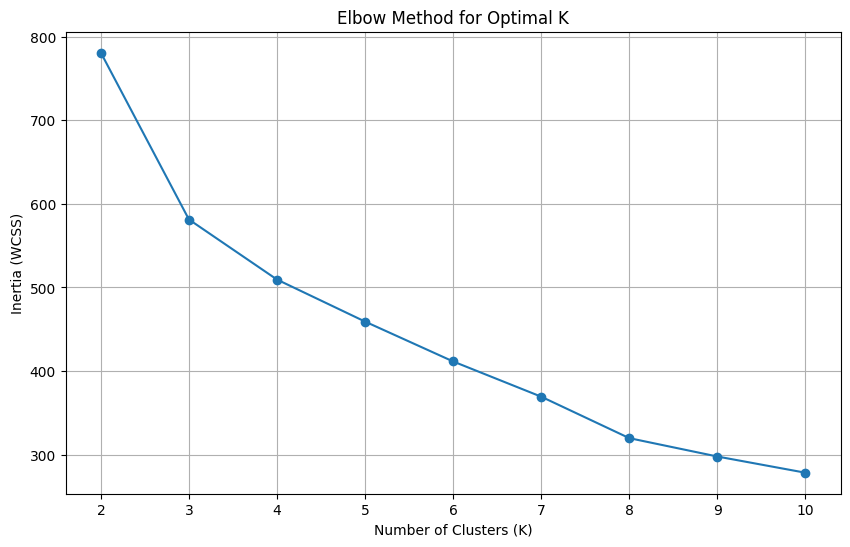


Chosen number of clusters (K): 4



In [96]:
# --- 2. Feature Engineering ---
# Calculate daily returns for Nifty (useful for future volatility/drawdown calc)
df['Nifty_Return'] = df['Nifty_Close'].pct_change()

# Calculate slopes/changes in breadth indicators (e.g., 5-day change)
slope_period = 5
df['Slope_20DMA'] = df['Pct_Above_20DMA'].diff(periods=slope_period)
df['Slope_50DMA'] = df['Pct_Above_50DMA'].diff(periods=slope_period)

# Drop rows with NaN values created by diff/pct_change
df.dropna(subset=['Nifty_Return', 'Slope_20DMA', 'Slope_50DMA'], inplace=True)

# Select features for clustering
# We use the breadth levels and their slopes
features_to_cluster = ['Pct_Above_20DMA', 'Pct_Above_50DMA', 'Slope_20DMA', 'Slope_50DMA']
X = df[features_to_cluster]

# Standardize features (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Determine Optimal K using Elbow Method ---
inertia = []
k_range = range(2, 11) # Test K from 2 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

# --- User Decision: Choose K based on the Elbow plot ---
# --- Let's assume K=4 looks reasonable from the plot ---
chosen_k = 4
print(f"\nChosen number of clusters (K): {chosen_k}\n")

# --- 4. Perform Clustering with Chosen K ---
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

# Add cluster labels back to the original DataFrame
df['Cluster'] = kmeans.labels_



In [97]:
df.tail(25)

,Nifty_Close,Pct_Above_20DMA,Pct_Above_50DMA,Nifty_Return,Slope_20DMA,Slope_50DMA,Cluster
date,,,,,,,
2025-02-18,22945.300781,33.0,26.4,-0.000618,-2.0,-12.4,3
2025-02-19,22932.900391,35.0,28.4,-0.000540,8.0,-6.0,2
2025-02-20,22913.150391,39.0,28.4,-0.000861,4.0,-2.8,2
2025-02-21,22795.900391,37.0,30.0,-0.005117,7.0,4.0,2
2025-02-25,22547.550781,20.0,27.6,-0.010894,-7.0,2.4,3
2025-02-27,22545.050781,20.0,25.6,-0.000111,-13.0,-0.8,3
2025-02-28,22124.699219,18.0,22.8,-0.018645,-17.0,-5.6,3
2025-03-03,22119.300781,11.0,20.0,-0.000244,-28.0,-8.4,3
2025-03-04,22082.650391,12.0,18.0,-0.001657,-25.0,-12.0,3


Cluster	Regime Type	Notes


1	Low Risk Long	Momentum + Breadth = Strong long setup


2	Mixed / Early Bull	Watch for trend continuation or chop


3	High Risk Long / Mean Reversion	Big upside, big risk


0	Weak Market / Short Bias	Breadth holding, but momentum fading

--- Average Feature Values per Cluster ---
         Pct_Above_20DMA  Pct_Above_50DMA  Slope_20DMA  Slope_50DMA
Cluster                                                            
0              65.766667        77.453333    -5.533333     2.446667
1              71.982759        59.448276    24.327586    13.758621
2              50.739130        16.539130    12.380435     0.821739
3              27.686747        41.734940   -23.590361   -10.534940
----------------------------------------

--- Future Performance Analysis (7-Day Horizon) per Cluster ---
         Count  Avg_Future_Return  Median_Future_Return  Std_Future_Return  \
Cluster                                                                      
0           60              -0.26                  0.27               2.14   
1           58              -0.03                  0.48               2.14   
2           92               0.14                  0.38               2.07   
3           83               0.75                  0.

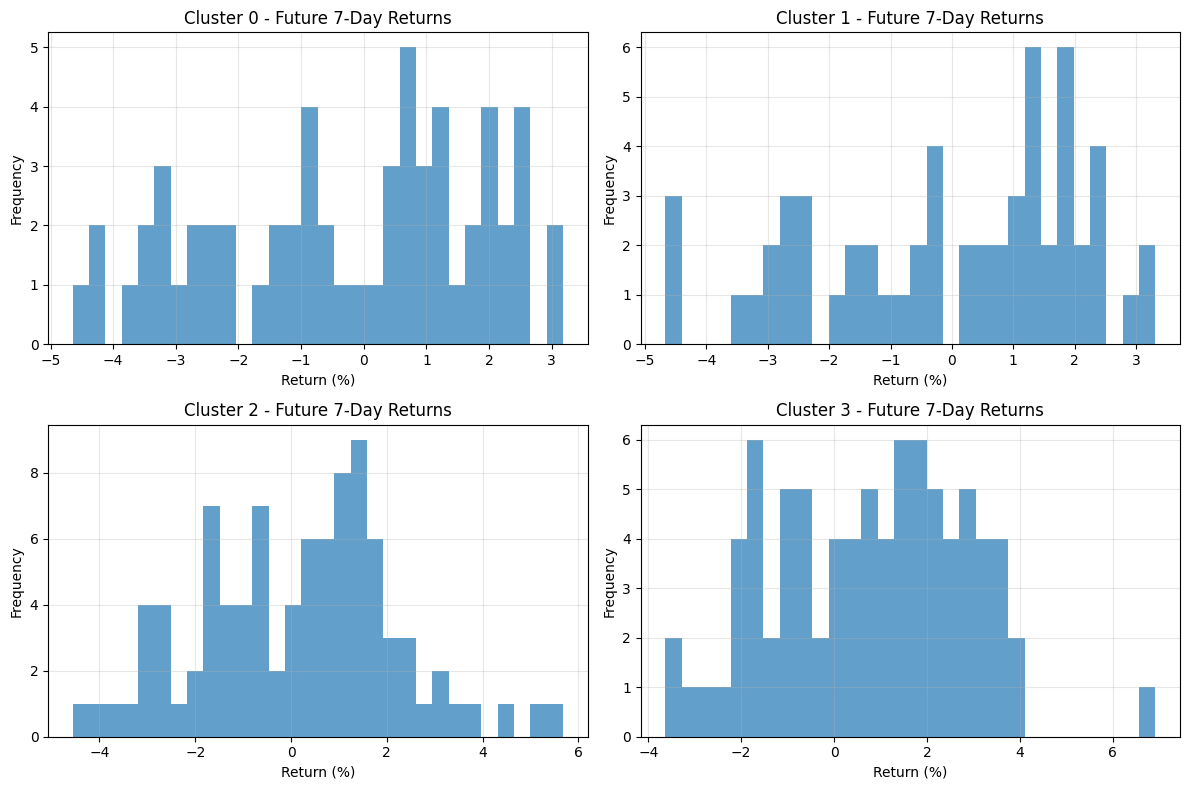

In [98]:

# --- 5. Analyze Future Risk/Performance per Cluster ---

# Define the future window (N days)
N = 7 # Look ahead 20 trading days (approx 1 month)

# Calculate N-day future return
df['N_Day_Future_Return'] = (df['Nifty_Close'].shift(-N) / df['Nifty_Close']) - 1

# Calculate N-day future volatility (standard deviation of daily returns)
# Use rolling on daily returns and shift result back
df['N_Day_Future_Vol'] = df['Nifty_Return'].rolling(window=N).std().shift(-N)

# Calculate N-day future maximum drawdown
# Function to calculate forward drawdown
def calculate_forward_mdd(series, n):
    rolling_max = series.rolling(window=n + 1, min_periods=1).max() # Max including current point
    drawdown = (series / rolling_max) - 1
    max_drawdown = drawdown.rolling(window=n + 1, min_periods=1).min() # Min drawdown over the window
    return max_drawdown

# Calculate rolling forward MDD and shift it back
mdd_series = calculate_forward_mdd(df['Nifty_Close'], N)
df['N_Day_Future_MDD'] = mdd_series.shift(-N)


# Drop rows where future calculations result in NaN (last N rows)
df.dropna(subset=['N_Day_Future_Return', 'N_Day_Future_Vol', 'N_Day_Future_MDD'], inplace=True)

# --- 6. Aggregate and Interpret Results ---

# Calculate average characteristics of the features *within* each cluster
cluster_features_mean = df.groupby('Cluster')[features_to_cluster].mean()
print("--- Average Feature Values per Cluster ---")
print(cluster_features_mean)
print("-" * 40)


# Analyze the *future* performance metrics grouped by cluster
cluster_analysis = df.groupby('Cluster').agg(
    Count=('Cluster', 'size'),
    Avg_Future_Return=('N_Day_Future_Return', 'mean'),
    Median_Future_Return=('N_Day_Future_Return', 'median'),
    Std_Future_Return=('N_Day_Future_Return', 'std'),
    Prob_Positive_Return=('N_Day_Future_Return', lambda x: (x > 0).mean()),
    Avg_Future_Vol=('N_Day_Future_Vol', 'mean'),
    Avg_Future_MDD=('N_Day_Future_MDD', 'mean') # Avg of the max drawdowns
)

# Convert returns/MDD to percentage for readability
cluster_analysis['Avg_Future_Return'] *= 100
cluster_analysis['Median_Future_Return'] *= 100
cluster_analysis['Std_Future_Return'] *= 100
cluster_analysis['Prob_Positive_Return'] *= 100
cluster_analysis['Avg_Future_Vol'] *= 100 # Daily vol -> percent
cluster_analysis['Avg_Future_MDD'] *= 100

print(f"\n--- Future Performance Analysis ({N}-Day Horizon) per Cluster ---")
print(cluster_analysis.round(2))
print("-" * 60)

print("\nInterpretation Guide:")
print("- Look for clusters with high Avg_Future_Return, high Prob_Positive_Return, low Avg_Future_MDD, low Avg_Future_Vol: Potential 'Low Risk (Long)' regime.")
print("- Look for clusters with low/negative Avg_Future_Return, low Prob_Positive_Return: Potential 'High Risk (Long) / Low Risk (Short)' regime.")
print("- Look for clusters with Avg_Future_Return near zero but high Std_Future_Return, high Avg_Future_Vol, high Avg_Future_MDD: Potential 'High Risk / Choppy' regime.")
print("- Compare these performance stats with the 'Average Feature Values per Cluster' to understand the market conditions (breadth levels/slopes) that define each regime.")

# --- Optional: Visualize Future Return Distributions ---
plt.figure(figsize=(12, 8))
for i in range(chosen_k):
    plt.subplot(2, 2, i + 1) # Adjust grid based on chosen_k
    cluster_data = df[df['Cluster'] == i]['N_Day_Future_Return'] * 100
    plt.hist(cluster_data, bins=30, alpha=0.7, label=f'Cluster {i}')
    plt.title(f'Cluster {i} - Future {N}-Day Returns')
    plt.xlabel('Return (%)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
